# Dominant colours - Introduction
This is the second part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook builds a dominant colours detection system based on K-Means clustering algorithm to find a list of 10 dominant colours and their distribution for each picture in the dataset.

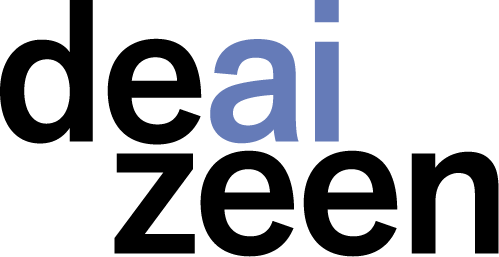

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.cluster import KMeans
import numpy as np



# from mpl_toolkits.mplot3d import Axes3D


# import timeit
# from tqdm import tqdm

# Colour detection

## Helper functions

In [78]:
def displayImage(img):
  
  if isinstance(img, str):
    # read image file & convert to rgb
    image = cv2.imread(img)
    image = cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
        ) 
  else:
    image = img
  
  # switch off axis
  plt.axis('off')

  # display image
  plt.imshow(image)

In [86]:
def preprocessImage(imagepath, dsize=(16,16)):

  # load image & convert to rgb
  image = cv2.imread(imagepath)
  image = cv2.cvtColor(
      image,
      cv2.COLOR_BGR2RGB
      )

  # scale down the image
  image = cv2.resize(
      image,
      dsize=dsize,
      interpolation=cv2.INTER_CUBIC
      )

  return image

In [91]:
def clusterColours(image):

  # reshape the image to a list of pixels
  image = image.reshape((image.shape[0] * image.shape[1],3))

  # cluster the color in the image
  clt = KMeans(n_clusters=clusters)
  clt.fit(image)

  return clt

In [96]:
def centroidHistogram(clt):

    # number of clusters
    numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
    # histrogram of the number of pixels
    (hist,_) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histrogram, such that it sums to one'
    hist = hist.astype('float')
    hist /= hist.sum()
    
    return hist

In [93]:
def colourBar(hist, clt):
    # init the rectable size
    bar = np.zeros((50,300,3), dtype='uint8')
    startX = 0
    
    # loop over the percentage of each color cluster and the color of eahc cluster
    for (percent, color) in zip(hist, clt.cluster_centers_):
        endX = startX + (percent*300)
        cv2.rectangle(bar,(int(startX),0),(int(endX),50),
                          color.astype("uint8").tolist(),-1)
        startX = endX
    
    return bar

## Test

In [116]:
path = '/mydrive/data/dezeen/1591814/hija-de-sanchez-cantina-restaurant-copenhagen-oeo-studio_dezeen_2364_col_0-852x1278.jpg'

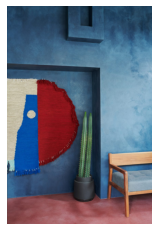

In [117]:
displayImage(path)

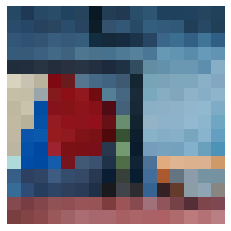

In [118]:
image = preprocessImage(path)
displayImage(image)

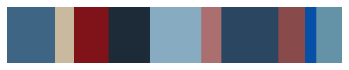

In [119]:
image = preprocessImage(path)
clt = clusterColours(image)
histogram = centroidHistogram(clt)
bar = colourBar(histogram, clt)

plt.figure()
plt.axis('off')
plt.imshow(bar)
plt.show()



In [ ]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# %matplotlib inline
# import argparse
# import cv2
# import numpy as np

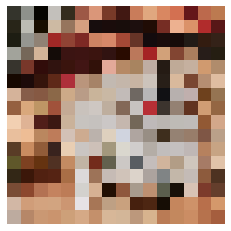

In [76]:
# # construct the argument parser and parse the arguments when executing in cmdline
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True, help="Path to image")
# ap.add_argument("-c", "--clusters", required=True, type = int,
               #help="number of clusters")
#args = vars(ap.parse_args())

# number of clusters
clusters = 10

# load the image and do conversions
image = cv2.imread('/mydrive/data/dezeen/1594490/pantechnicon-london-store-interiors-japanese-nordic-farrells_dezeen_2364_col_29-852x568.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# show image
plt.figure()
plt.axis("off")
plt.imshow(image)

# scale down the image
image = cv2.resize(image, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)

# reshape the image to a list of pixels
image = image.reshape((image.shape[0] * image.shape[1],3))


In [ ]:
# cluster the color in the image
clt = KMeans(n_clusters=clusters)
clt.fit(image)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
colours = clt.cluster_centers_
colours

array([[ 19.13265306,  21.84693878,  40.01020408],
       [100.        , 111.86956522, 110.56521739],
       [149.48387097, 173.70967742, 172.70967742],
       [  6.78947368,  17.        , 249.        ],
       [ 54.97222222,  63.47222222,  70.11111111],
       [209.66666667, 234.83333333, 188.16666667],
       [113.29411765,  30.47058824,  42.82352941],
       [216.5       , 106.5       , 232.        ],
       [ 10.35714286,  20.        , 147.85714286],
       [101.375     , 213.25      ,  90.        ]])

In [ ]:
def rgb_to_hsv(colour):
    r, g, b = colour[0]/255.0, colour[1]/255.0, colour[2]/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    colours = [h, s, v]
    return colours

In [ ]:
colours_hsv = [rgb_to_hsv(color) for color in clt.cluster_centers_]

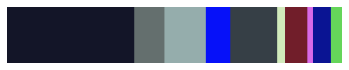

In [ ]:
hist = centroid_histrogram(clt)
bar = plot_color(hist, clt.cluster_centers_)

# display
plt.figure()
plt.axis("off")
valid_imshow_data(bar)
plt.imshow(bar)
plt.show()

In [ ]:
hist = centroid_histrogram(clt)
bar = plot_color(hist, colours_hsv)

# display
plt.figure()
plt.axis("off")
valid_imshow_data(bar)
plt.imshow(bar)
plt.show()

AttributeError: ignored

In [ ]:
def clusterColors(filepath, clusters=10, res=(32,32)):
  # load the image and do conversions
  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  # reshape the image to a list of pixels
  # image = image.reshape((image.shape[0]*image.shape[1], 3))

  # scale down the image
  image = cv2.resize(image, dsize=res, interpolation=cv2.INTER_CUBIC)

  # reshape the image to a list of pixels
  image = image.reshape((image.shape[0]*image.shape[1], 3))

  # cluster the color in the image
  clt = KMeans(n_clusters=clusters)
  clt.fit(image)

  return clt

In [ ]:
def centroid_histrogram(clt):
    # number of clusters
    numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
    # histrogram of the number of pixels
    (hist,_) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histrogram, such that it sums to one'
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist

In [ ]:
def plot_color(hist, centroids):
    # init the rectable size
    bar = np.zeros((50,300,3), dtype="uint8")
    startX = 0
    
    # loop over the percentage of each color cluster and the color of eahc cluster
    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent*300)
        cv2.rectangle(bar,(int(startX),0),(int(endX),50),
                          color.astype("uint8").tolist(),-1)
        startX = endX
    
    return bar

In [ ]:
# def valid_imshow_data(data):
#     data = np.asarray(data)
#     if data.ndim == 2:
#         return True
#     elif data.ndim == 3:
#         if 3 <= data.shape[2] <= 4:
#             return True
#         else:
#             print('The "data" has 3 dimensions but the last dimension '
#                   'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
#                   ''.format(data.shape[2]))
#             return False
#     else:
#         print('To visualize an image the data must be 2 dimensional or '
#               '3 dimensional, not "{}".'
#               ''.format(data.ndim))
#         return False

In [ ]:
clt.cluster_centers_

array([[131.43478261, 151.56521739, 149.2173913 ],
       [ 18.20430108,  20.83870968,  39.48387097],
       [ 80.76923077,  98.26923077,  90.26923077],
       [  6.78947368,  17.        , 249.        ],
       [176.77272727, 202.86363636, 182.18181818],
       [116.52941176,  26.47058824,  50.47058824],
       [ 47.19354839,  53.06451613,  64.16129032],
       [ 90.57142857, 211.42857143,  87.57142857],
       [ 10.35714286,  20.        , 147.85714286],
       [216.5       , 106.5       , 232.        ]])

# Test loop

In [ ]:
# start = timeit.default_timer() # start the times

# with open('/mydrive/files/tmp/dezeen-images-0.txt') as fp:
#   data = fp.read() 

# linklist = data.split('\n')
# cltlist = []
# histlist = []

# for link in tqdm(linklist):
#   try:
#     clt = clusterColors(link, 10)
#     cltlist.append(clt)
#     histlist.append(centroid_histrogram(clt))
#   except:
#     cltlist.append(np.nan)
#     histlist.append(np.nan)



# stop = timeit.default_timer() # stop the timer
# print('Runtime: {} seconds.'.format(stop-start))

Streaming output truncated to the last 5000 lines.




 50%|█████     | 1000/1999 [07:40<10:17,  1.62it/s]




 50%|█████     | 1001/1999 [07:40<09:35,  1.74it/s]




 50%|█████     | 1002/1999 [07:41<09:05,  1.83it/s]




 50%|█████     | 1003/1999 [07:41<08:44,  1.90it/s]




 50%|█████     | 1004/1999 [07:42<09:26,  1.75it/s]




 50%|█████     | 1005/1999 [07:43<10:28,  1.58it/s]




 50%|█████     | 1006/1999 [07:43<10:26,  1.59it/s]




 50%|█████     | 1007/1999 [07:44<09:41,  1.70it/s]




 50%|█████     | 1008/1999 [07:45<11:47,  1.40it/s]




 50%|█████     | 1009/1999 [07:45<10:26,  1.58it/s]




 51%|█████     | 1010/1999 [07:46<09:27,  1.74it/s]




 51%|█████     | 1011/1999 [07:46<08:32,  1.93it/s]




 51%|█████     | 1012/1999 [07:47<08:50,  1.86it/s]




 51%|█████     | 1013/1999 [07:47<08:45,  1.88it/s]




 51%|█████     | 1014/1999 [07:48<09:41,  1.69it/s]




 51%|█████     | 1015/1999 [07:49<09:41,  1.69it/s]




 51%|█████     | 1016/1999 [07:50<11:56,  1.37it/

Runtime: 1083.755972303 seconds.


In [ ]:
import sys

all_colours_in_hsv = [colour1, colour2, colour3, colour4, colour5]

def closest_colour(selected_colour):
    # set the distance to be a reallly big number
    # initialise closest_colour to empty
    shortest_distance, closest_colour = sys.max(), None

    # iterate through all the colours
    # for each colour in the list, find the Euclidean distance to the one selected by the user
    for colour in all_colours_in_hsv:
        # since your colours are in 3D space, perform the calculation in each respective space
        current_distance = sqrt(pow(colour.H - selected_colour.H, 2) + pow(colour.S - selected_colour.S, 2) + pow(colour.V - selected_colour.V, 2))

        # unless you truly care about the exact length, then you don't need to perform the sqrt() operation.
        # it is a rather expensive one so you can just do this instead
        # current_distance = pow(colour.H - selected_colour.H, 2) + pow(colour.S - selected_colour.S, 2) + pow(colour.V - selected_colour.V, 2)

        # update the distance along with the corresponding colour
        if current_distance < shortest_distance:
            shortest_distance = current_distance
            closest_colour = colour

    return shortest_distance, closest_colour

https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
https://i.pinimg.com/236x/31/07/e7/3107e7aded0502e633a6f9b5cda52991--colour-palettes-colour-schemes.jpg
https://github.com/rodartha/ColorPalette/
https://github.com/shourya1997/K-Means-Color-Clustering/blob/master/color_kmeans.ipynb
https://medium.com/swlh/getting-dominant-colour-of-an-image-using-k-means-f7fdca880063
https://github.com/pfnet-research/FSCS
https://answers.opencv.org/question/186712/find-an-image-by-nearest-color/
https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=XrFmZBr9KtAN
https://ailephant.com/dominant-colors-in-image-with-k-means/
